In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.linear_model import RidgeCV


os.getcwd()

'/Users/blake_hartung/Documents/FALL 2022/ocean-depth-characterization/EDA'

In [2]:
PROFILE_DATA_PATH = "../data/profileData.csv"
SAT_DATA_PATH = "../data/satData.csv"

profile_df = pd.read_csv(PROFILE_DATA_PATH)
sat_df = pd.read_csv(SAT_DATA_PATH)

In [5]:
profile_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37469410 entries, 0 to 37469409
Data columns (total 8 columns):
 #   Column       Dtype  
---  ------       -----  
 0   float        int64  
 1   cycleNumber  int64  
 2   date         object 
 3   PRES         int64  
 4   PSAL         float64
 5   TEMP         float64
 6   BBP700       float64
 7   CHLA         float64
dtypes: float64(4), int64(3), object(1)
memory usage: 2.2+ GB


In [3]:
float_ids = np.unique(profile_df.float)
num_floats = len(float_ids)
print(f"Total number of floats with proper sensors: {num_floats}")

Total number of floats with proper sensors: 569


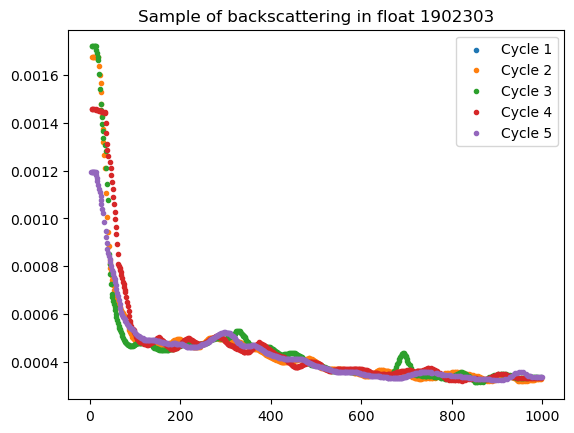

In [5]:
float = profile_df[profile_df.float == np.random.choice(float_ids)]
for i in range(5):
    plt.scatter(float[float.cycleNumber == i].PRES, float[float.cycleNumber == i].BBP700, marker=".")
plt.legend([f"Cycle {i+1}" for i in range(5)])
plt.title("Sample of backscattering in float {}".format(float_ids[0]))
plt.show()

In [34]:
cycle1 = profile_df[profile_df.cycleNumber == 1]

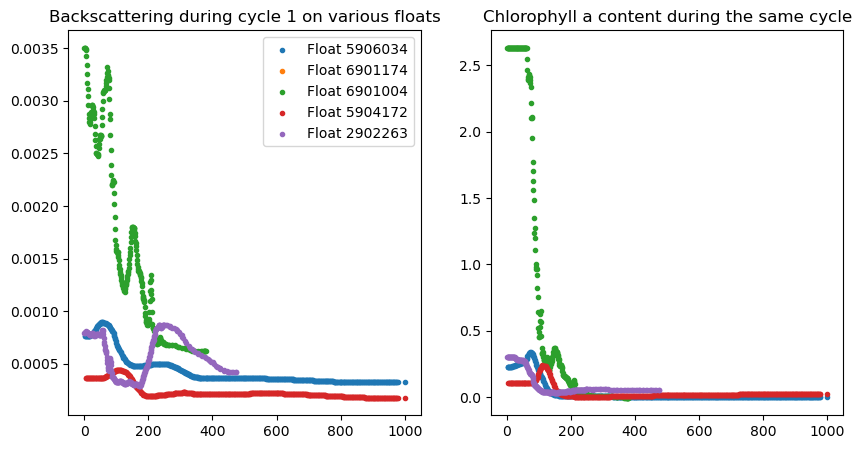

In [59]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))
float_ls = np.random.choice(float_ids, size=5)
for rand_float in float_ls:
    ax[0].scatter(cycle1[cycle1.float == rand_float].PRES, cycle1[cycle1.float == rand_float].BBP700, marker=".")
    ax[1].scatter(cycle1[cycle1.float == rand_float].PRES, cycle1[cycle1.float == rand_float].CHLA, marker=".")
ax[0].legend([f"Float {f}" for f in float_ls])
ax[0].set_title("Backscattering during cycle 1 on various floats")
ax[1].set_title("Chlorophyll a content during the same cycle")
plt.show()

In [53]:
sat_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66271 entries, 0 to 66270
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   float           66271 non-null  int64  
 1   cycleNumber     66271 non-null  int64  
 2   date            66271 non-null  object 
 3   latitude        66271 non-null  float64
 4   longitude       66271 non-null  float64
 5   elevation       66271 non-null  float64
 6   MO_SAT_SST      62358 non-null  float64
 7   MO_SAT_CHL      52921 non-null  float64
 8   MO_SAT_BBP      52760 non-null  float64
 9   LT_SAT_SST_SD   62993 non-null  float64
 10  LT_SAT_SST_MED  62994 non-null  float64
 11  LT_SAT_CHL_SD   66267 non-null  float64
 12  LT_SAT_CHL_MED  62991 non-null  float64
 13  LT_SAT_BBP_SD   62990 non-null  float64
 14  LT_SAT_BBP_MED  62991 non-null  float64
dtypes: float64(12), int64(2), object(1)
memory usage: 7.6+ MB


In [101]:
# Aggregate profile data using the mean value of chlorophyll a and bbp700 nm in the sunlit portion of the ocean
sunlit_profiles = profile_df[profile_df.PRES < 151][['float', 'cycleNumber', 'CHLA', 'BBP700']] \
    .groupby(['float', 'cycleNumber']).mean().reset_index()
df = sat_df.merge(sunlit_profiles, on=['float', 'cycleNumber']).drop(['MO_SAT_SST', 'LT_SAT_SST_SD', 'LT_SAT_SST_MED'], axis=1).dropna()

In [102]:
df.corr(method="spearman").style.background_gradient()

,float,cycleNumber,latitude,longitude,elevation,MO_SAT_CHL,MO_SAT_BBP,LT_SAT_CHL_SD,LT_SAT_CHL_MED,LT_SAT_BBP_SD,LT_SAT_BBP_MED,CHLA,BBP700
float,1.000000,-0.021539,0.287061,-0.134443,0.383253,0.146128,0.007923,0.154369,0.154991,0.007600,0.030789,0.001153,-0.000221
cycleNumber,-0.021539,1.000000,0.034964,0.073951,-0.009740,-0.049839,-0.059966,-0.063609,-0.054457,-0.022552,-0.059451,-0.062624,-0.086323
latitude,0.287061,0.034964,1.000000,-0.120019,0.326236,0.166403,-0.299580,0.212122,0.199888,-0.122310,-0.361066,-0.285663,-0.250109
longitude,-0.134443,0.073951,-0.120019,1.000000,0.113045,0.046343,0.005762,0.078313,0.035184,0.072668,-0.041666,0.118768,0.070757
elevation,0.383253,-0.009740,0.326236,0.113045,1.000000,0.353230,0.024615,0.411893,0.375418,0.213411,0.037014,0.139067,0.114513
MO_SAT_CHL,0.146128,-0.049839,0.166403,0.046343,0.353230,1.000000,0.431436,0.801559,0.863496,0.722092,0.521292,0.625523,0.584686
MO_SAT_BBP,0.007923,-0.059966,-0.299580,0.005762,0.024615,0.431436,1.000000,0.312236,0.383613,0.496706,0.633741,0.586339,0.639169
LT_SAT_CHL_SD,0.154369,-0.063609,0.212122,0.078313,0.411893,0.801559,0.312236,1.000000,0.917159,0.783592,0.491670,0.522569,0.517629
LT_SAT_CHL_MED,0.154991,-0.054457,0.199888,0.035184,0.375418,0.863496,0.383613,0.917159,1.000000,0.828044,0.607525,0.589411,0.548771
LT_SAT_BBP_SD,0.007600,-0.022552,-0.122310,0.072668,0.213411,0.722092,0.496706,0.783592,0.828044,1.000000,0.774992,0.677246,0.626214


In [116]:
Xc = df[["latitude", "MO_SAT_CHL", "LT_SAT_CHL_MED"]]
yc = df["CHLA"]
Xb = df[["latitude", "MO_SAT_BBP", "LT_SAT_BBP_MED"]]
yb = df["BBP700"]

rclf_c = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1], cv=5, scoring='neg_mean_squared_error').fit(Xc, yc)
print("Initial score for ridgereg [CHLA]: {}".format(rclf_c.score(Xc, yc)))

rclf_b = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1], cv=5, scoring='neg_mean_squared_error').fit(Xb, yb)
print("Initial score for ridgereg [BBP700]: {}".format(rclf_b.score(Xb, yb)))

Initial score for ridgereg [CHLA]: 0.3595110935118697
Initial score for ridgereg [BBP700]: 0.004973481008056058


### Questions / Comments on Neural Net Paper

1. How are the input values giving four "potential density values along the vertical profile" derived? (aren't those theoretically very similar to the output values we are trying to achieve? Are they using some aggregation of past float values based on time / location?)

2. Clarification on the use of Z_norm values and their relationship to attenuation coefficients at very specific wavelengths. Further clarification on the lack of similarity between Z_norm calculation between stratified and mixed water columns. (How are they finding this "statistical optimality")

3. What pieces of the dataset we have in hand are similar to the data they calculated / used (what do we have and what else do we need to calculate to repeat / extend their work)